# Novelty Detection Considering ART Approach

## Cross Validation

The cross validation is done by randomly dividing the data into a number of boxes and selecting random boxes as train, test and validation sets. The data is considered for each acquisition run, of every ship. That is, the boxes and selections are done for each acquisition run. Later, they are appended in order to train the classifier with data from every acquisition. This guarantees that most of the signal stochasticity is seen by the classifier.

## Classifier

Classifier trained conidering the data projection onto the PCD's extracted by the independent model.

# Results

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas
from sklearn.externals import joblib
# Network import: should be in the path if framework configured correctly
import neuralnet as nn
import PyNN.NeuralNet as PyNNet
import PyNN.TrnInfo as PyTrnInfo
import copy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools
import scipy as sc

# Standard styles for each class
dashes = [[],[10,10],[10,4,2,4],[10,5,100,5]] 
colors = ['b','r','g','y']
markers= ['o','s','^','d']

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['legend.handlelength'] = 3
mpl.rcParams['legend.borderpad'] = 0.3
mpl.rcParams['legend.numpoints'] = 1


classes = np.array(['ClasseA','ClasseB','ClasseC','ClasseD'])
noveltyclasses = np.array(['ClasseA','ClasseB','ClasseC','ClasseD'])
#noveltyclasses = np.array(['ClasseA'])
sonarhome = os.getenv('SONARHOME')
fname = sonarhome + '/data/lofar_data_1024fft_3dec_fromMat.jbl'
pcddir = sonarhome + '/results/classification/novelty/PCD_Independent/'
nPts = 400

In [2]:
# Load and divide data
globaldata = joblib.load(fname)
cls_data = {}
for cls in classes:
    cls_data[cls] = np.concatenate([y['Signal'][:nPts] for y in globaldata[cls].values()], axis=1).transpose()
def novelty_data(clsnov, data):
    use_classes = np.sort(np.setdiff1d(data.keys(), clsnov))
    Xnov = np.concatenate([data[cls] for cls in clsnov], axis=0)
    X = np.concatenate([data[cls] for cls in use_classes], axis=0)
    nClass = len(use_classes)
    T = None
    for icls, cls in enumerate(use_classes):
        tot = data[cls].shape[0]
        if nClass == 2:
            aux = -np.ones(1)
            aux[0] = 1 if icls > 0 else -1
        else:
            aux = -np.ones(nClass)
            aux[icls] = 1
        T = np.tile(aux,(tot,1)) if T is None else np.concatenate((T, np.tile(aux,(tot,1))))
    return X, T, Xnov

## PCD Network

In [3]:
nov_pcdnet = {}
npcd = 18
IPCD = {
    'ClasseA': 8,
    'ClasseB': 6,
    'ClasseC': 1,
    'ClasseD': 7
}
artdir = sonarhome + '/results/classification/novelty/PCD%02i_ARTIndependent/'%npcd
for cls in noveltyclasses:
    filepcd = pcddir + '/pcdind_cv_' + cls + '_fromMat_1024nfft.jbl'
    PCD = joblib.load(filepcd)
    nov_pcdnet[cls] = {}
    NCV = PCD['cvPar']['CVNSel']
    nov_pcdnet[cls]['Net'] = [PCD['PCDModel'].results[icv].PCDNets[npcd-1] for icv in range(NCV)]
    nov_pcdnet[cls]['Classifier'] = [PCD['Classifier'].results[icv][npcd].nnets[npcd] for icv in range(NCV)]
    nov_pcdnet[cls]['Classes'] = PCD['Classes']
del PCD
del filepcd

## ART Classifier

In [4]:
nov_art = {}
for cls in noveltyclasses:
    fileart = artdir + '/art_pcdind%i_cv_'%npcd + cls + '_fromMat_1024nfft.jbl'
    nov_art[cls] = joblib.load(fileart)
del fileart

## Performance Over Initial Radius

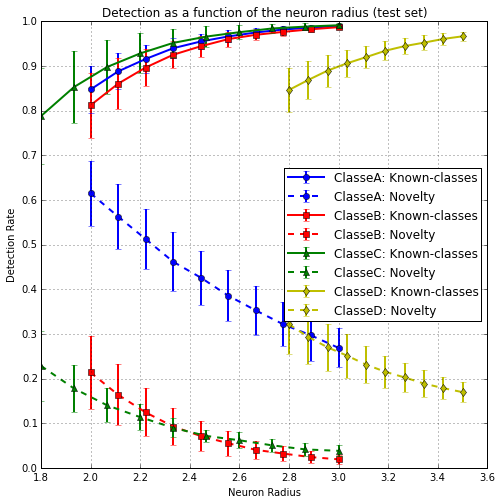

In [5]:
plt.figure(figsize=(8,8), facecolor='w')
for inov, novcls in enumerate(noveltyclasses):
    nGridPar = len(nov_art[novcls]['ARTModel'].results[0][0])
    NCV      = nov_art[novcls]['cvPar']['CVNSel']
    tpr = np.zeros((NCV, nGridPar))
    fpr = np.zeros((NCV, nGridPar))
    sps = np.zeros((NCV, nGridPar))
    # Known-classes and novelty
    Xpar = np.array(nov_art[novcls]['ARTModel'].results[0][1]['Performance'].keys())
    idx = np.argsort(Xpar)
    Xpar = Xpar[idx]
    for icv in range(NCV):
        tpr[icv] = np.array(nov_art[novcls]['ARTModel'].results[icv][1]['Performance'].values())[idx]
        fpr[icv] = np.array(nov_art[novcls]['ARTModel'].results[icv][1]['NoveltyPerf'].values())[idx]
        sps[icv] = np.sqrt(np.sqrt(tpr[icv] * fpr[icv]) * ((tpr[icv] + fpr[icv])/2.0))
    # PLOT
    icls = np.nonzero(classes == novcls)[0][0]
    plt.errorbar(Xpar, np.mean(tpr,axis=0), np.std(tpr,axis=0),
                 color=colors[icls], fmt='-', marker=markers[icls],
                 label=novcls+': Known-classes')
    plt.errorbar(Xpar, np.mean(fpr,axis=0), np.std(fpr,axis=0),
                 color=colors[icls], fmt='--', marker=markers[icls],
                 label=novcls+': Novelty')
    # Plot labels
    plt.grid(True)
    plt.xlabel('Neuron Radius')
    plt.ylabel('Detection Rate')
    plt.title('Detection as a function of the neuron radius (test set)')
    plt.gca().set_yticks(np.linspace(0,1,11))
    plt.ylim([0, 1])
plt.legend(loc='best').get_frame().set_facecolor('w')

## Simulation

In [6]:
from sklearn.externals import joblib
fsimul = sonarhome + '/data/art_pcdind%i_simul.jbl'%npcd
#fsimul = None
Y = {}
data = {}
if fsimul is not None:
    simul = joblib.load(fsimul)
    Y = simul['Y']
    data = simul['data']
else:
    for novcls in noveltyclasses:
        print 'Novelty: ', novcls, ', CVs ',
        Y[novcls] = {}
        data[novcls] = {}
        NCV = nov_art[novcls]['cvPar']['CVNSel']
        data[novcls]['Labels'] = nov_pcdnet[novcls]['Classes']
        # Get PCD
        X, T, Xnov = novelty_data([novcls], cls_data)
        data[novcls]['Target'] = T
        # SImulate
        for icv in range(NCV):
            print icv,' ',
            sys.stdout.flush()
            Y[novcls][icv] = {}
            data[novcls][icv] = {}
            # Input
            trn_info = nov_pcdnet[novcls]['Classifier'][icv].trn_info
            nnet = nov_pcdnet[novcls]['Net'][icv]
            W = nov_pcdnet[novcls]['Net'][icv].W[0]
            data[novcls][icv]['Input'] = W.dot(X.transpose()).transpose()
            data[novcls][icv]['InNov'] = W.dot(Xnov.transpose()).transpose()
            idx = np.array([False] * T.shape[0])
            idx[trn_info.itst] = True
            data[novcls][icv]['ITest'] = idx
            # Output per class
            nnet = nov_pcdnet[novcls]['Classifier'][icv]
            Y[novcls][icv]['NetOut'] = nnet.feedforward(data[novcls][icv]['Input'])
            Y[novcls][icv]['NetNov'] = nnet.feedforward(data[novcls][icv]['InNov'])
            # For each radius
            Y[novcls][icv]['ARTOut'] = {}
            Y[novcls][icv]['ARTNov'] = {}
            for rad in nov_art[novcls]['ARTModel'].results[icv][0].keys():
                artnet = nov_art[novcls]['ARTModel'].results[icv][0][rad]
                Xart = artnet.trn_data_norm.transform(data[novcls][icv]['Input'])
                Y[novcls][icv]['ARTOut'][rad] = artnet.classify(Xart)
                XartNov = artnet.trn_data_norm.transform(data[novcls][icv]['InNov'])
                Y[novcls][icv]['ARTNov'][rad] = artnet.classify(XartNov)
        print '. Done.'
    fsimul = sonarhome + '/data/art_pcdind%i_simul.jbl'%npcd
    simul = {'Y':Y, 'data':data}
    joblib.dump(simul, fsimul, compress=9)

## ART Radius

### ART + NNet

In [7]:
def plot_art_net_dist(novcls, net_out, art_out, net_thr, art_thr):
    plt.figure(figsize = (12,5), facecolor='w')
    plt.subplot(1,2,1)    
    plt.plot(net_out, art_out, 'ok')
    ax = plt.axis()
    plt.plot([net_thr, net_thr], ax[2:], '--r') # Net threshold
    plt.plot(ax[:2], [art_thr, art_thr], '--r') # ART threshold
    plt.xlabel('Neural Network Output')
    plt.ylabel('ART Distance')
    plt.grid(True)
    plt.subplot(1,2,2)
    #h2 = plt.hist2d(net_out,art_out, [20,10], cmap = plt.cm.Greys);
    h2 = np.histogram2d(art_out, net_out, [20,20])
    ms = plt.matshow(np.flipud(np.abs(h2[0])), cmap=plt.cm.Greys, fignum=0, extent=[0,1,0,1],
                     norm=mpl.colors.LogNorm())
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.plot([(net_thr+1)/2, (net_thr+1)/2], [0,1], '--r') # Net threshold
    plt.plot([0,1], [(art_thr-ax[2])/(ax[3]-ax[2]), (art_thr-ax[2])/(ax[3]-ax[2])], '--r') # ART threshold
    plt.gca().autoscale(False)
    plt.gca().set_xticks(np.linspace(0,1,len(h2[2]+1)))
    plt.gca().set_xticklabels(['%.2f'%x for x in np.linspace(-1, 1,len(h2[2]+1))])
    plt.gca().set_yticks(np.linspace(0,1,len(h2[1]+1)))
    plt.gca().set_yticklabels(['%.2f'%x for x in np.linspace(ax[2], ax[3],len(h2[1]+1))])
    plt.xticks(rotation='90')
    plt.xlabel('Neural Network Output')
    plt.ylabel('ART Distance')
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", "5%", pad="3%")
    plt.colorbar(ms, cax=cax)


In [8]:
novcls = 'ClasseA'
icv = IPCD[novcls]
min_det = 0.9
itst = data[novcls][icv]['ITest']
# Find radius for 90% at known-classes
eff_rad = np.array([[rad, (Y[novcls][icv]['ARTOut'][rad][1][itst] != -1).sum()/float(itst.sum())]
                    for rad in np.sort(Y[novcls][icv]['ARTOut'].keys())])
rad = eff_rad[ np.nonzero(eff_rad[:,1] >= min_det)[0][0], 0]
net_thr = 0.75
art_out = rad - Y[novcls][icv]['ARTOut'][rad][0][itst]
net_out = np.max(Y[novcls][icv]['NetOut'][itst,:], axis=1)
art_nov = rad - Y[novcls][icv]['ARTNov'][rad][0]
net_nov = np.max(Y[novcls][icv]['NetNov'], axis=1)

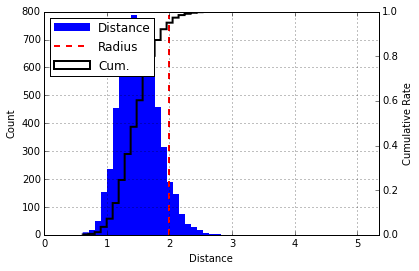

In [9]:
# ART Radius Distribution - Known CLasses
h0 = plt.hist(art_out, 50, edgecolor='none', label='Distance');
h1 = plt.plot([rad, rad],[0, h0[0].max()], '--r', label='Radius')
plt.ylabel('Count')
plt.xlabel('Distance')
plt.grid(True)
ax = plt.gca().twinx()
h2 = ax.hist(art_out, 50, cumulative=True, histtype = 'step', color='k', normed=True, lw=2, label='Cum.');
plt.ylim([0, 1])
plt.xlim([0, art_out.max()*0.99])
plt.ylabel('Cumulative Rate')
plt.legend(handles=[h0[2][0],h1[0],h2[2][0]],loc='upper left').get_frame().set_facecolor('1')

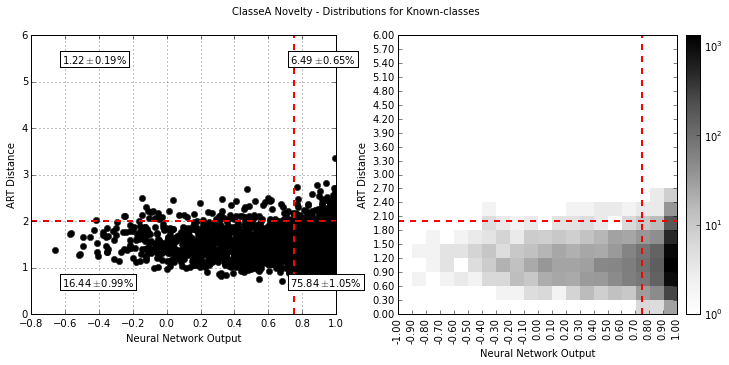

In [10]:
# NNet and ARTNet
plot_art_net_dist(novcls, net_out, art_out, net_thr, rad)
plt.gcf().suptitle(novcls + ' Novelty - Distributions for Known-classes')
# Calculate quarters for known class
CM_avg = np.zeros((2,2))
CM_std = np.zeros((2,2))
effs = np.zeros((4, len(Y[novcls])))
for icv in range(len(Y[novcls])):
    itst = data[novcls][icv]['ITest']
    # Find radius for 90% at known-classes
    eff_rad = np.array([[rad, (Y[novcls][icv]['ARTOut'][rad][1][itst] != -1).sum()/float(itst.sum())]
                        for rad in np.sort(Y[novcls][icv]['ARTOut'].keys())])
    rad = eff_rad[ np.nonzero(eff_rad[:,1] >= min_det)[0][0], 0]
    i_art = Y[novcls][icv]['ARTOut'][rad][1][itst] < 0
    i_net = np.max(Y[novcls][icv]['NetOut'][itst,:], axis=1) >= net_thr
    # 1st quarter: > ART, < NN
    effs[0,icv] = float((i_art & ~i_net).sum()) / i_net.shape[0]
    # 2nd quarter: > ART, > NN
    effs[1,icv] = float((i_art & i_net).sum()) / i_net.shape[0]
    # 3rd quarter: < ART, < NN
    effs[2,icv] = float((~i_art & ~i_net).sum()) / i_net.shape[0]
    # 4th quarter: < ART, > NN
    effs[3,icv] = float((~i_art & i_net).sum()) / i_net.shape[0]
plt.subplot(1,2,1)
plt.text(0.10, 0.9, r'%.2f$\pm$%.2f%%'%(100*np.mean(effs[0]), 100*np.std(effs[0])),
         transform=plt.gca().transAxes, bbox=dict(facecolor='w'))
plt.text(0.85, 0.9, r'%.2f$\pm$%.2f%%'%(100*np.mean(effs[1]), 100*np.std(effs[1])),
         transform=plt.gca().transAxes, bbox=dict(facecolor='w'))
plt.text(0.10, 0.1, r'%.2f$\pm$%.2f%%'%(100*np.mean(effs[2]), 100*np.std(effs[2])),
         transform=plt.gca().transAxes, bbox=dict(facecolor='w'))
plt.text(0.85, 0.1, r'%.2f$\pm$%.2f%%'%(100*np.mean(effs[3]), 100*np.std(effs[3])),
         transform=plt.gca().transAxes, bbox=dict(facecolor='w'))

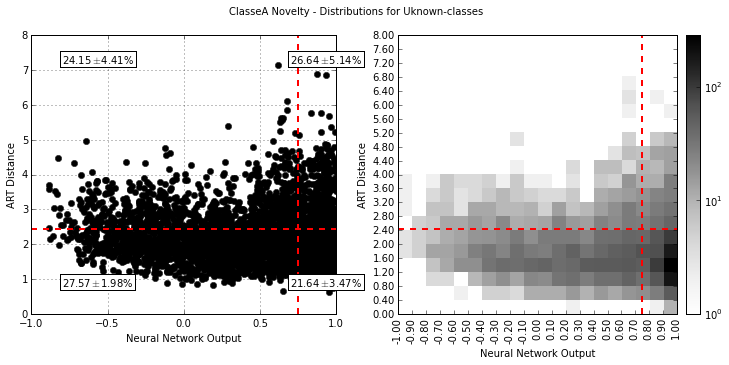

In [11]:
# NNet and ARTNet - NOvelty
plot_art_net_dist(novcls, net_nov, art_nov, net_thr, rad)
plt.gcf().suptitle(novcls + ' Novelty - Distributions for Uknown-classes')
# Calculate quarters for Unknown class
CM_avg = np.zeros((2,2))
CM_std = np.zeros((2,2))
effs = np.zeros((4, len(Y[novcls])))
for icv in range(len(Y[novcls])):
    itst = data[novcls][icv]['ITest']
    # Find radius for 90% at known-classes
    eff_rad = np.array([[rad, (Y[novcls][icv]['ARTOut'][rad][1][itst] != -1).sum()/float(itst.sum())]
                        for rad in np.sort(Y[novcls][icv]['ARTOut'].keys())])
    rad = eff_rad[ np.nonzero(eff_rad[:,1] >= min_det)[0][0], 0]
    i_art = Y[novcls][icv]['ARTNov'][rad][0] < 0
    i_net = np.max(Y[novcls][icv]['NetNov'], axis=1) > net_thr
    # 1st quarter: > ART, < NN
    effs[0,icv] = float((i_art & ~i_net).sum()) / i_net.shape[0]
    # 2nd quarter: > ART, > NN
    effs[1,icv] = float((i_art & i_net).sum()) / i_net.shape[0]
    # 3rd quarter: < ART, < NN
    effs[2,icv] = float((~i_art & ~i_net).sum()) / i_net.shape[0]
    # 4th quarter: < ART, > NN
    effs[3,icv] = float((~i_art & i_net).sum()) / i_net.shape[0]
plt.subplot(1,2,1)
plt.text(0.10, 0.9, r'%.2f$\pm$%.2f%%'%(100*np.mean(effs[0]), 100*np.std(effs[0])),
         transform=plt.gca().transAxes, bbox=dict(facecolor='w'))
plt.text(0.85, 0.9, r'%.2f$\pm$%.2f%%'%(100*np.mean(effs[1]), 100*np.std(effs[1])),
         transform=plt.gca().transAxes, bbox=dict(facecolor='w'))
plt.text(0.10, 0.1, r'%.2f$\pm$%.2f%%'%(100*np.mean(effs[2]), 100*np.std(effs[2])),
         transform=plt.gca().transAxes, bbox=dict(facecolor='w'))
plt.text(0.85, 0.1, r'%.2f$\pm$%.2f%%'%(100*np.mean(effs[3]), 100*np.std(effs[3])),
         transform=plt.gca().transAxes, bbox=dict(facecolor='w'))

In [12]:
def plot_confusion(CM_avg, CM_std, labels, nocolorbar=False):
    labels = np.concatenate(([''], labels))
    ms = plt.matshow(CM_avg, cmap=plt.cm.Blues, vmin=0, vmax=100, fignum=0)
    plt.gca().set_xticklabels(labels, size=14)
    plt.gca().set_yticklabels(labels, size=14)
    for i in range(CM_avg.shape[0]):
        for j in range(CM_avg.shape[1]):
            color = 'k'if CM_avg[i,j] < 70 else 'w'
            if CM_std is not None:
                plt.text(j,i,'%.2f\n$\pm$\n%.2f'%(CM_avg[i,j], CM_std[i,j]), ha='center',
                         va='center',size=14, color=color, weight='bold')
            else:
                plt.text(j,i,'%.2f'%(CM_avg[i,j]), ha='center', va='center',size=14, color=color, weight='bold')
    plt.xlabel('Detection', size=14)
    plt.ylabel('Truth', size=14)
    #title = plt.title(r'Confusion Matrix (%)', va='bottom')
    #title.set_y(1.09) 
    if not nocolorbar:
        divider = make_axes_locatable(plt.gca())
        cax = divider.append_axes("right", "5%", pad="3%")
        plt.colorbar(ms, cax=cax)
        plt.ylabel('%')
    return ms

## ART + NNet Operation - Confusion Matrix

ClasseA 	Average known as novelty: 92.28 +- 0.68
ClasseB 	Average known as novelty: 91.40 +- 0.94
ClasseC 	Average known as novelty: 91.63 +- 0.84
ClasseD 	Average known as novelty: 90.61 +- 0.36


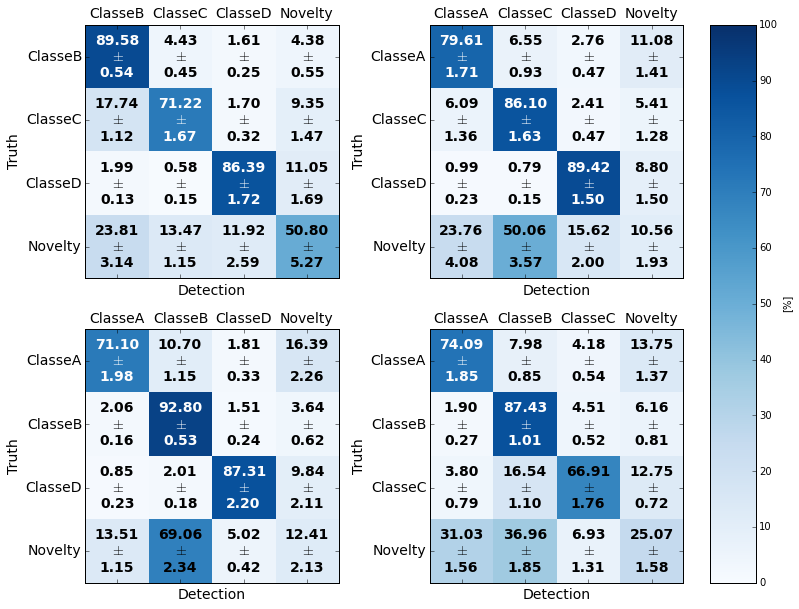

In [18]:
from sklearn.metrics import confusion_matrix
fig = plt.figure(figsize = (13, 10), facecolor='w')
min_art_det = 0.9
# Loop over novelties
CM_ART_avg = {}
CM_ART_std = {}
axes = [None]*4
for inov, novcls in enumerate(noveltyclasses):
    axes[inov] = plt.subplot(2,2,inov+1)
    NCV = nov_art[novcls]['cvPar']['CVNSel']
    T = np.argmax(data[novcls]['Target'], 1)
    # Loop over cross-validation
    eff = [None]*NCV
    tot_as_nov = np.zeros(NCV)
    tot_known = np.zeros(NCV)        
    for icv in range(NCV):
        itst = data[novcls][icv]['ITest']
        # Find radius for 90% at known-classes
        eff_rad = np.array([[rad, (Y[novcls][icv]['ARTOut'][rad][1][itst] != -1).sum()/float(itst.sum())]
                            for rad in np.sort(Y[novcls][icv]['ARTOut'].keys())])
        idx = np.nonzero(eff_rad[:,1] >= min_art_det)[0]
        if not len(idx):
            idx = np.nonzero(eff_rad[:,1] <= min_art_det)[0]
            idx = idx[::-1]
        rad = eff_rad[idx[0], 0]
        i_art = Y[novcls][icv]['ARTOut'][rad][1][itst] < 0 # detected as novelty
        i_nov = Y[novcls][icv]['ARTNov'][rad][1] < 0
        Yout = np.argmax(Y[novcls][icv]['NetOut'][itst], 1)
        Ynov = np.argmax(Y[novcls][icv]['NetNov'], 1)
        # Make Target and output with novelty
        cmT  = np.concatenate((T[itst], np.ones(Ynov.shape[0])*len(noveltyclasses)))
        Yout[i_art] = len(noveltyclasses)
        Ynov[i_nov] = len(noveltyclasses)
        cmY = np.concatenate((Yout, Ynov))
        cm = confusion_matrix(cmT, cmY)
        eff[icv] = (cm.T / np.array(cm.sum(1),'f')).T
        tot_as_nov[icv] = np.sum(cm[:3,3])
        tot_known[icv] = float(itst.sum())
    tot_as_nov = (1-tot_as_nov / tot_known) * 100
    print novcls,'\tAverage known as novelty: %.2f +- %.2f'%(np.mean(tot_as_nov), np.std(tot_as_nov))        
    CM_ART_avg[novcls] = np.array(eff).mean(axis=0) * 100
    CM_ART_std[novcls] = np.array(eff).std(axis=0) * 100
    ms = plot_confusion(CM_ART_avg[novcls], CM_ART_std[novcls],
                        np.concatenate((data[novcls]['Labels'], ['Novelty'])), nocolorbar=True)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, axes[3].get_position().y0, 0.05, (axes[0].get_position().y1-
                                                                axes[3].get_position().y0)])
fig.colorbar(ms, cax=cbar_ax)
plt.ylabel('[%]')

## NNet Operation - Confusion Matrix

ClasseA 	Average known as novelty: 92.21 +- 0.58
ClasseB 	Average known as novelty: 91.42 +- 1.16
ClasseC 	Average known as novelty: 91.58 +- 0.78
ClasseD 	Average known as novelty: 90.61 +- 0.67


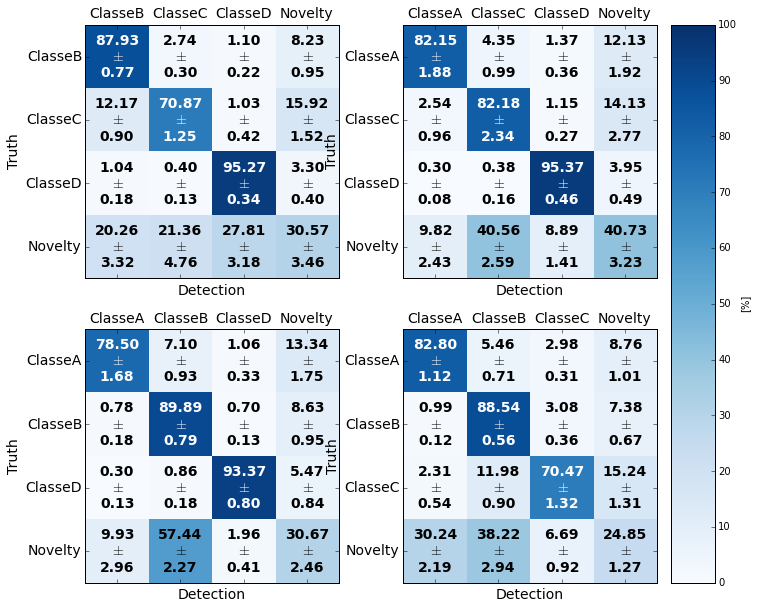

In [20]:
from sklearn.metrics import confusion_matrix
fig = plt.figure(figsize = (13, 10), facecolor='w')
min_det_thr = { # depends on where the total efficiency crosses 90%
    'ClasseA': 0.40,
    'ClasseB': 0.59,
    'ClasseC': 0.55,
    'ClasseD': 0.30
}
# Loop over novelties
CM_MLP_avg = {}
CM_MLP_std = {}
for inov, novcls in enumerate(noveltyclasses):
    axes[inov] = plt.subplot(2,2,inov+1)
    NCV = nov_art[novcls]['cvPar']['CVNSel']
    T = np.argmax(data[novcls]['Target'], 1)
    # Loop over cross-validation
    eff = [None]*NCV
    tot_as_nov = np.zeros(NCV)
    tot_known = np.zeros(NCV)            
    for icv in range(NCV):
        itst = data[novcls][icv]['ITest']
        i_art = np.max(Y[novcls][icv]['NetOut'][itst],1) < min_det_thr[novcls] # detected as novelty
        i_nov = np.max(Y[novcls][icv]['NetNov'],1) < min_det_thr[novcls]
        Yout = np.argmax(Y[novcls][icv]['NetOut'][itst], 1)
        Ynov = np.argmax(Y[novcls][icv]['NetNov'], 1)
        # Make Target and output with novelty
        cmT  = np.concatenate((T[itst], np.ones(Ynov.shape[0])*len(noveltyclasses)))
        Yout[i_art] = len(noveltyclasses)
        Ynov[i_nov] = len(noveltyclasses)
        cmY = np.concatenate((Yout, Ynov))
        cm = confusion_matrix(cmT, cmY)
        eff[icv] = (cm.T / np.array(cm.sum(1),'f')).T
        tot_as_nov[icv] = np.sum(cm[:3,3])
        tot_known[icv] = float(itst.sum())
    tot_as_nov = (1-tot_as_nov / tot_known) * 100
    print novcls,'\tAverage known as novelty: %.2f +- %.2f'%(np.mean(tot_as_nov), np.std(tot_as_nov)) 
    CM_MLP_avg[novcls] = np.array(eff).mean(axis=0) * 100
    CM_MLP_std[novcls] = np.array(eff).std(axis=0) * 100
    ms = plot_confusion(CM_MLP_avg[novcls], CM_MLP_std[novcls],
                        np.concatenate((data[novcls]['Labels'], ['Novelty'])), nocolorbar=True)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, axes[3].get_position().y0, 0.05, (axes[0].get_position().y1-
                                                                axes[3].get_position().y0)])
fig.colorbar(ms, cax=cbar_ax)
plt.ylabel('[%]')

### Confusion Matrixes Combined

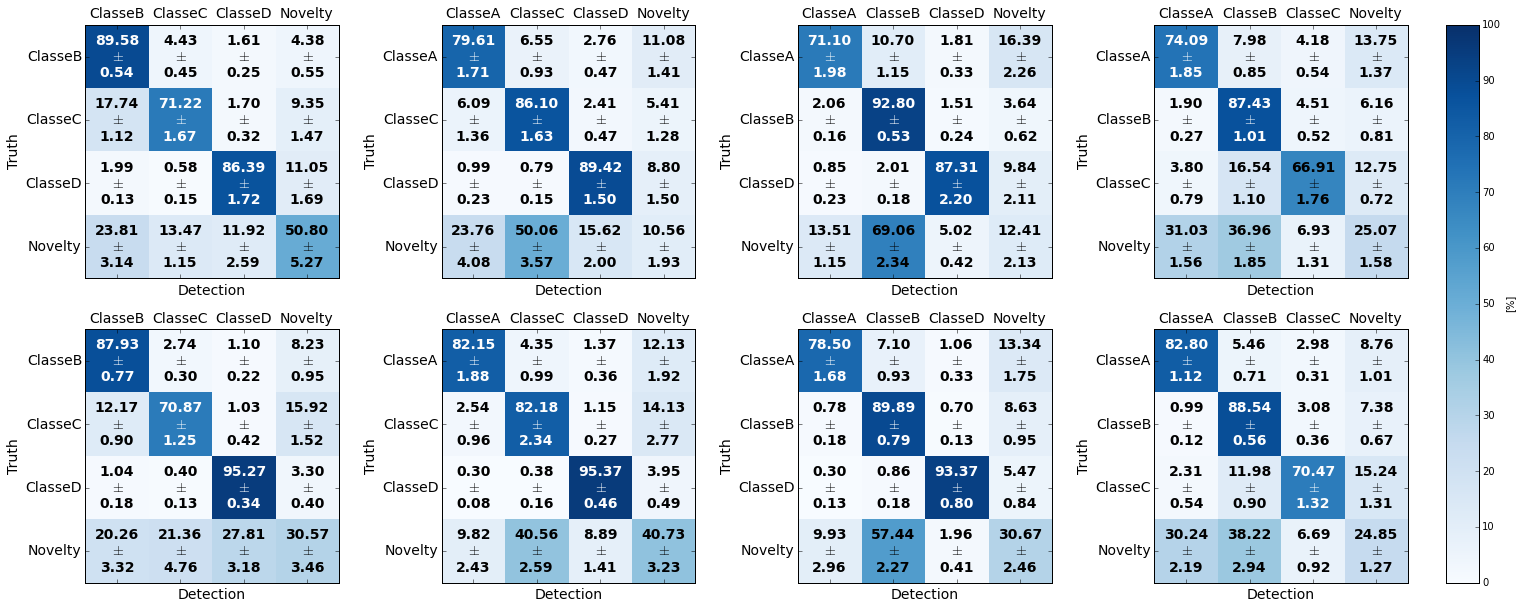

In [21]:
from sklearn.metrics import confusion_matrix
fig = plt.figure(figsize = (23, 10), facecolor='w')
# Loop over novelties
axes = [None]*8
for inov, novcls in enumerate(noveltyclasses):
    axes[inov] = plt.subplot(2,4,inov+1)
    ms = plot_confusion(CM_ART_avg[novcls], CM_ART_std[novcls],
                        np.concatenate((data[novcls]['Labels'], ['Novelty'])), nocolorbar=True)
    axes[inov+4] = plt.subplot(2,4,inov+1+4)
    ms = plot_confusion(CM_MLP_avg[novcls], CM_MLP_std[novcls],
                        np.concatenate((data[novcls]['Labels'], ['Novelty'])), nocolorbar=True)
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, axes[7].get_position().y0, 0.02, (axes[0].get_position().y1-
                                                                axes[7].get_position().y0)])
fig.colorbar(ms, cax=cbar_ax)
plt.ylabel('[%]')